## START


In [1]:
%reset -f

In [2]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
BASEMAP_PROVIDERS = {
    "positron": ctx.providers.CartoDB.Positron,
    "dark": ctx.providers.CartoDB.DarkMatter,
    "osm": ctx.providers.OpenStreetMap.Mapnik,
    "satellite": ctx.providers.Esri.WorldImagery,
}

PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa una basemap se contextily è disponibile
    "basemap": "positron"                     # scegli tra: positron, toner, terrain, osm, satellite
}



In [3]:
# === 1. AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === 2. Scarica dati OSM uso del suolo ===
tags = {
    "landuse": True,
    "amenity": True,
    "building": True,
    "leisure": True,
    "natural": True,
    "boundary": True,
}

if hasattr(ox, "features_from_polygon"):
    gdf_mix = ox.features_from_polygon(aoi, tags=tags)
else:
    gdf_mix = ox.geometries_from_polygon(aoi, tags=tags)

# Filtra solo poligoni
gdf_mix = gdf_mix[gdf_mix.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clippa sull'AOI
gdf_mix = gpd.clip(gdf_mix, aoi_gdf)

# === 3. Classificazione uso del suolo (8 categorie: aggiunto verde pubblico/privato) ===
def classifica_landuse(row):
    # --- helper mini ---
    def norm(v):
        return "" if v is None else str(v).strip().lower()
    def in_set(val, choices):
        if not val:
            return False
        parts = {p.strip() for ch in (";", "|") for p in str(val).lower().replace(ch, ";").split(";") if p.strip()}
        return any(c in parts for c in choices)

    lu   = norm(row.get("landuse"))
    am   = norm(row.get("amenity"))
    bd   = norm(row.get("building"))
    le   = norm(row.get("leisure"))
    na   = norm(row.get("natural"))
    bdry = norm(row.get("boundary"))
    access   = norm(row.get("access"))
    operator = norm(row.get("operator"))
    shop = norm(row.get("shop"))
    landcover = norm(row.get("landcover"))
    buse = norm(row.get("building:use"))

    # ========== VERDE (esteso) ==========
    if (
        in_set(le, {"park","garden","recreation_ground","nature_reserve","common",
                    "playground","pitch","dog_park","fitness_station"}) or
        in_set(lu, {"grass","meadow","recreation_ground","village_green",
                    "orchard","allotments","farmland","greenfield","forest","cemetery","flowerbed"}) or
        in_set(na, {"wood","forest","grassland","heath","scrub","wetland","tree_row"}) or
        in_set(landcover, {"grass","meadow","trees"}) or
        bdry == "protected_area"
    ):
        if ("public" in access) or ("municipal" in operator) or ("comune" in operator) or in_set(le, {"park","recreation_ground"}):
            return "Verde pubblico"
        else:
            return "Verde"

    # ========== SANITARIO ==========
    if in_set(am, {"hospital","clinic","doctors"}) or in_set(bd, {"hospital","clinic"}):
        return "Sanitario"

    # ========== EDUCATIVO ==========
    if in_set(am, {"school","university","college","kindergarten"}) or in_set(bd, {"school","university","college"}):
        return "Educativo"

    # ========== ISTITUZIONALE (pubblico, culto, amministrativo) ==========
    if (
        # amenity legati a funzioni pubbliche o religiose vere
        in_set(am, {"townhall", "public_building", "library", "courthouse", 
                    "police", "fire_station", "prison", "place_of_worship"}) or
        # building di tipo pubblico/religioso
        in_set(bd, {"public", "civic", "government", "church", "chapel"}) or
        # landuse o operator con traccia di ente pubblico
        "public" in operator or "municipal" in operator or "comune" in operator
    ):
        return "Istituzionale"


    # ========== INDUSTRIALE ==========
    if (lu == "industrial") or in_set(bd, {"industrial","warehouse","factory","hangar","service"}):
        return "Industriale"

    # ========== RESIDENZIALE (potenziata) ==========
    # segnali netti + building:use + multi-valore
    if (
        lu == "residential" or
        in_set(bd, {"house","apartments","residential","detached",
                    "terrace","terraced_house","row_house","semidetached_house",
                    "dormitory","bungalow","villa"}) or
        in_set(buse, {"residential","apartments","dormitory"})
    ):
        return "Residenziale"

    # euristica forte per building=yes: se non ci sono indizi di commerciale/industriale/istituzionale,
    # e c'è un minimo indizio residenziale (indirizzo o lu=residential), classifichiamo come Residenziale.
    bd_tokens = {p.strip() for p in bd.replace("|",";").split(";") if p.strip()}
    addr_present = any(norm(row.get(k)) for k in ("addr:housenumber","addr:street","addr:unit"))

    negative_building = {
        # tipi di building che NON vogliamo marcare residenziali
        "warehouse","factory","industrial","stadium","grandstand","church","chapel",
        "train_station","office","hotel","school","university","college","clinic","hospital",
        "shed","transformer","ruins","construction","service","hangar","roof","barn","farm_auxiliary"
    }

    if (
        (bd in {"yes","building"} or "yes" in bd_tokens) and
        not (in_set(bd, negative_building) or in_set(am, {
            "marketplace","bank","bar","cafe","fast_food","restaurant","pub",
            "pharmacy","fuel","post_office","telecommunication","atm","cinema","arts_centre",
            "parking","motorcycle_parking","parking_space","place_of_worship"
        }) or shop or lu in {"commercial","retail","industrial"}) and
        (addr_present or lu == "residential")
    ):
        return "Residenziale"

    # ========== COMMERCIALE ==========
    if (lu in {"commercial","retail"}) or \
       in_set(bd, {"retail","commercial","supermarket","kiosk","mall","hotel","office"}) or \
       in_set(am, {"marketplace","bank","bar","cafe","fast_food","restaurant","pub",
                   "pharmacy","fuel","post_office","telecommunication","atm","cinema","arts_centre"}):
        return "Commerciale"

    # ========== Fallback ==========
    return None


gdf_mix["landuse_class"] = gdf_mix.apply(classifica_landuse, axis=1)
gdf_classified = gdf_mix.dropna(subset=["landuse_class"]).copy()

# === 4. Edifici (building only) ===
building_tags = {"building": True}
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)

# === 5. Acque: poligoni e linee ===
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua (fiumi, canali)
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)

# Filtro: solo corsi d'acqua visibili
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
else:
    water_line_visible = water_line

water_line3857 = water_line_visible.to_crs(3857)

# === 6. Proiezione uso del suolo e AOI ===
gdf_classified_3857 = gdf_classified.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# === 7. Output statistico ===
print("Geometrie totali:", len(gdf_mix))
print("Geometrie classificate:", len(gdf_classified))
print("Classi individuate:", gdf_classified['landuse_class'].nunique())
print(gdf_classified["landuse_class"].value_counts())


Geometrie totali: 28212
Geometrie classificate: 4620
Classi individuate: 8
landuse_class
Verde             2114
Residenziale      1715
Commerciale        213
Verde pubblico     176
Educativo          152
Istituzionale      108
Industriale        103
Sanitario           39
Name: count, dtype: int64


In [4]:
from shapely.ops import linemerge, unary_union
# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

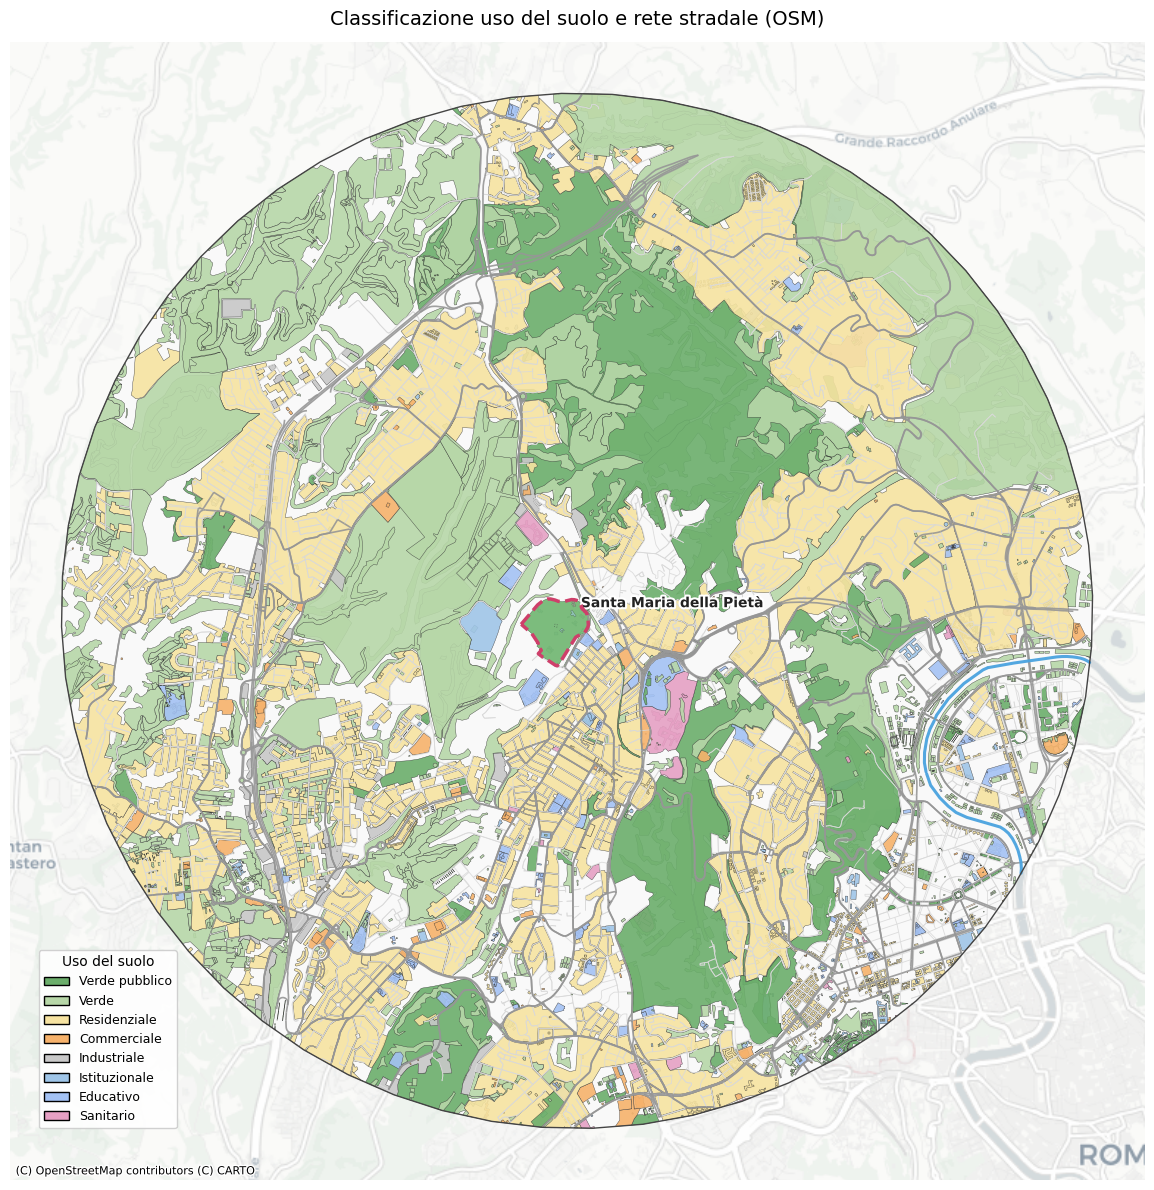

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE USO DEL SUOLO ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === CREA FIGURA ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro AOI ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni uso del suolo ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- Contorno AOI ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# --- Evidenzia Comprensorio Verde ---
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(ax=ax, color="#CE3F6A", linewidth=2.5, linestyle="--", zorder=150)
    gdf_verde_hit.plot(ax=ax, color="#81C784", alpha=0.4, edgecolor=None, zorder=140)

# --- Corsi d'acqua (linee) ---
WATER_LINE_COLOR = "#4AA3DF"
if 'water_line3857' in globals() and water_line3857 is not None and not water_line3857.empty:
    wl = water_line3857.copy()
    if wl.crs is None or int(str(wl.crs).split(":")[-1]) != 3857:
        wl = wl.to_crs(3857)
    try:
        wl = wl.explode(index_parts=False, ignore_index=True)
    except TypeError:
        wl = wl.explode(index_parts=False)
    if 'waterway' not in wl.columns:
        wl['waterway'] = ""
    wtyp = wl['waterway'].astype(str).str.lower().str.strip()
    width_map = {'river': 2.2, 'canal': 1.8, 'stream': 1.2, 'ditch': 1.0, 'drain': 1.0}
    Z_WATER = 42
    done_mask = None
    for t, lw in width_map.items():
        mask = (wtyp == t)
        if mask.any():
            wl.loc[mask].plot(
                ax=ax,
                color=WATER_LINE_COLOR,
                linewidth=lw,
                alpha=0.95,
                zorder=Z_WATER,
                capstyle="round"
            )
        done_mask = mask if done_mask is None else (done_mask | mask)
    if done_mask is not None and (~done_mask).any():
        wl.loc[~done_mask].plot(
            ax=ax,
            color=WATER_LINE_COLOR,
            linewidth=0.9,
            alpha=0.9,
            zorder=Z_WATER,
            capstyle="round"
        )

# --- Etichetta ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# --- Legenda ---
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# --- Titolo e output ---
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()


In [6]:
gdf_verde_hit.to_file("verde_smdp.geojson", driver="GeoJSON")


## FOCUS CON POI

In [7]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

# === Parametri ===
BASEMAP_PROVIDERS = {
    "positron": ctx.providers.CartoDB.Positron,
    "dark": ctx.providers.CartoDB.DarkMatter,
    "osm": ctx.providers.OpenStreetMap.Mapnik,
    "satellite": ctx.providers.Esri.WorldImagery,
}

PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 3500,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa una basemap se contextily è disponibile
    "basemap": "positron"                     # scegli tra: positron, toner, terrain, osm, satellite
}

# === 1. AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === 2. Scarica dati OSM uso del suolo ===
tags = {
    "landuse": True,
    "amenity": True,
    "building": True,
    "leisure": True,
    "natural": True,
    "boundary": True,
}

if hasattr(ox, "features_from_polygon"):
    gdf_mix = ox.features_from_polygon(aoi, tags=tags)
else:
    gdf_mix = ox.geometries_from_polygon(aoi, tags=tags)

# Filtra solo poligoni
gdf_mix = gdf_mix[gdf_mix.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clippa sull'AOI
gdf_mix = gpd.clip(gdf_mix, aoi_gdf)

# === 3. Classificazione uso del suolo (8 categorie: aggiunto verde pubblico/privato) ===
def classifica_landuse(row):
    # --- helper mini ---
    def norm(v):
        return "" if v is None else str(v).strip().lower()
    def in_set(val, choices):
        if not val:
            return False
        parts = {p.strip() for ch in (";", "|") for p in str(val).lower().replace(ch, ";").split(";") if p.strip()}
        return any(c in parts for c in choices)

    lu   = norm(row.get("landuse"))
    am   = norm(row.get("amenity"))
    bd   = norm(row.get("building"))
    le   = norm(row.get("leisure"))
    na   = norm(row.get("natural"))
    bdry = norm(row.get("boundary"))
    access   = norm(row.get("access"))
    operator = norm(row.get("operator"))
    shop = norm(row.get("shop"))
    landcover = norm(row.get("landcover"))
    buse = norm(row.get("building:use"))

    # ========== VERDE (esteso) ==========
    if (
        in_set(le, {"park","garden","recreation_ground","nature_reserve","common",
                    "playground","pitch","dog_park","fitness_station"}) or
        in_set(lu, {"grass","meadow","recreation_ground","village_green",
                    "orchard","allotments","farmland","greenfield","forest","cemetery","flowerbed"}) or
        in_set(na, {"wood","forest","grassland","heath","scrub","wetland","tree_row"}) or
        in_set(landcover, {"grass","meadow","trees"}) or
        bdry == "protected_area"
    ):
        if ("public" in access) or ("municipal" in operator) or ("comune" in operator) or in_set(le, {"park","recreation_ground"}):
            return "Verde pubblico"
        else:
            return "Verde"

    # ========== SANITARIO ==========
    if in_set(am, {"hospital","clinic","doctors"}) or in_set(bd, {"hospital","clinic"}):
        return "Sanitario"

    # ========== EDUCATIVO ==========
    if in_set(am, {"school","university","college","kindergarten"}) or in_set(bd, {"school","university","college"}):
        return "Educativo"

    # ========== ISTITUZIONALE (sport, culto, parcheggi, PA) ==========
# ========== ISTITUZIONALE (pubblico, culto, amministrativo) ==========
    if (
        # amenity legati a funzioni pubbliche o religiose vere
        in_set(am, {"townhall", "public_building", "library", "courthouse", 
                    "police", "fire_station", "prison", "place_of_worship"}) or
        # building di tipo pubblico/religioso
        in_set(bd, {"public", "civic", "government", "church", "chapel"}) or
        # landuse o operator con traccia di ente pubblico
        "public" in operator or "municipal" in operator or "comune" in operator
    ):
        return "Istituzionale"


    # ========== INDUSTRIALE ==========
    if (lu == "industrial") or in_set(bd, {"industrial","warehouse","factory","hangar","service"}):
        return "Industriale"

    # ========== RESIDENZIALE (potenziata) ==========
    # segnali netti + building:use + multi-valore
    if (
        lu == "residential" or
        in_set(bd, {"house","apartments","residential","detached",
                    "terrace","terraced_house","row_house","semidetached_house",
                    "dormitory","bungalow","villa"}) or
        in_set(buse, {"residential","apartments","dormitory"})
    ):
        return "Residenziale"

    # euristica forte per building=yes: se non ci sono indizi di commerciale/industriale/istituzionale,
    # e c'è un minimo indizio residenziale (indirizzo o lu=residential), classifichiamo come Residenziale.
    bd_tokens = {p.strip() for p in bd.replace("|",";").split(";") if p.strip()}
    addr_present = any(norm(row.get(k)) for k in ("addr:housenumber","addr:street","addr:unit"))

    negative_building = {
        # tipi di building che NON vogliamo marcare residenziali
        "warehouse","factory","industrial","stadium","grandstand","church","chapel",
        "train_station","office","hotel","school","university","college","clinic","hospital",
        "shed","transformer","ruins","construction","service","hangar","roof","barn","farm_auxiliary"
    }

    if (
        (bd in {"yes","building"} or "yes" in bd_tokens) and
        not (in_set(bd, negative_building) or in_set(am, {
            "marketplace","bank","bar","cafe","fast_food","restaurant","pub",
            "pharmacy","fuel","post_office","telecommunication","atm","cinema","arts_centre",
            "parking","motorcycle_parking","parking_space","place_of_worship"
        }) or shop or lu in {"commercial","retail","industrial"}) and
        (addr_present or lu == "residential")
    ):
        return "Residenziale"

    # ========== COMMERCIALE ==========
    if (lu in {"commercial","retail"}) or \
       in_set(bd, {"retail","commercial","supermarket","kiosk","mall","hotel","office"}) or \
       in_set(am, {"marketplace","bank","bar","cafe","fast_food","restaurant","pub",
                   "pharmacy","fuel","post_office","telecommunication","atm","cinema","arts_centre"}):
        return "Commerciale"

    # ========== Fallback ==========
    return None




gdf_mix["landuse_class"] = gdf_mix.apply(classifica_landuse, axis=1)
gdf_classified = gdf_mix.dropna(subset=["landuse_class"]).copy()

# === 4. Edifici (building only) ===
building_tags = {"building": True}
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi, tags=building_tags)
else:
    buildings = ox.geometries_from_polygon(aoi, tags=building_tags)

buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
buildings = gpd.clip(buildings, aoi_gdf)
buildings3857 = buildings.to_crs(3857)

# === 5. Acque: poligoni e linee ===
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua (fiumi, canali)
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)

# Filtro: solo corsi d'acqua visibili
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
else:
    water_line_visible = water_line

water_line3857 = water_line_visible.to_crs(3857)

# === 6. Proiezione uso del suolo e AOI ===
gdf_classified_3857 = gdf_classified.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# === 7. Output statistico ===
print("Geometrie totali:", len(gdf_mix))
print("Geometrie classificate:", len(gdf_classified))
print("Classi individuate:", gdf_classified['landuse_class'].nunique())
print(gdf_classified["landuse_class"].value_counts())



Geometrie totali: 13364
Geometrie classificate: 1803
Classi individuate: 8
landuse_class
Verde             783
Residenziale      760
Educativo          57
Commerciale        53
Verde pubblico     47
Industriale        43
Istituzionale      40
Sanitario          20
Name: count, dtype: int64


In [8]:
from shapely.ops import linemerge, unary_union
# --- STRADE (rete "drive" nell'AOI) ---
edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)
edges_minor3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

try:
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

    # Classifica le strade
    MAJOR_BASE = {"motorway", "trunk", "primary", "secondary", "tertiary"}

    def normalize_highway(hw):
        if hw is None or (isinstance(hw, float) and pd.isna(hw)):
            return []
        if isinstance(hw, (list, set, tuple)):
            vals = list(hw)
        else:
            vals = [hw]
        cleaned = []
        for v in vals:
            s = str(v).lower().strip()
            if s.endswith("_link"):
                s = s[:-5]
            cleaned.append(s)
        return cleaned

    def classify_road(hw):
        base_vals = normalize_highway(hw)
        return "major" if any(b in MAJOR_BASE for b in base_vals) else "minor"

    # Applica classificazione e conversione CRS
    edges["road_class"] = edges["highway"].apply(classify_road)
    edges3857 = edges.to_crs(3857)
    edges_major3857 = edges3857[edges3857["road_class"] == "major"].copy()
    edges_minor3857 = edges3857[edges3857["road_class"] == "minor"].copy()

except Exception as e:
    print("Errore durante il caricamento delle strade:", e)

# Rendi disponibili per il plot
globals()["edges_major3857"] = edges_major3857
globals()["edges_minor3857"] = edges_minor3857

def unisci_segmenti(gdf):
    if gdf.empty:
        return gpd.GeoDataFrame(geometry=[], crs=gdf.crs)

    # Unisci tutte le geometrie in un'unica MultiLineString e poi fondi le connessioni
    merged = linemerge(unary_union(gdf.geometry))
    
    # Se il risultato è una singola LineString, lo mettiamo in una lista
    if merged.geom_type == "LineString":
        geometries = [merged]
    else:
        geometries = list(merged.geoms)

    return gpd.GeoDataFrame(geometry=geometries, crs=gdf.crs)

# Crea versioni "fuse" per il test o il plot
edges_major_fused = unisci_segmenti(edges_major3857)
edges_minor_fused = unisci_segmenti(edges_minor3857)

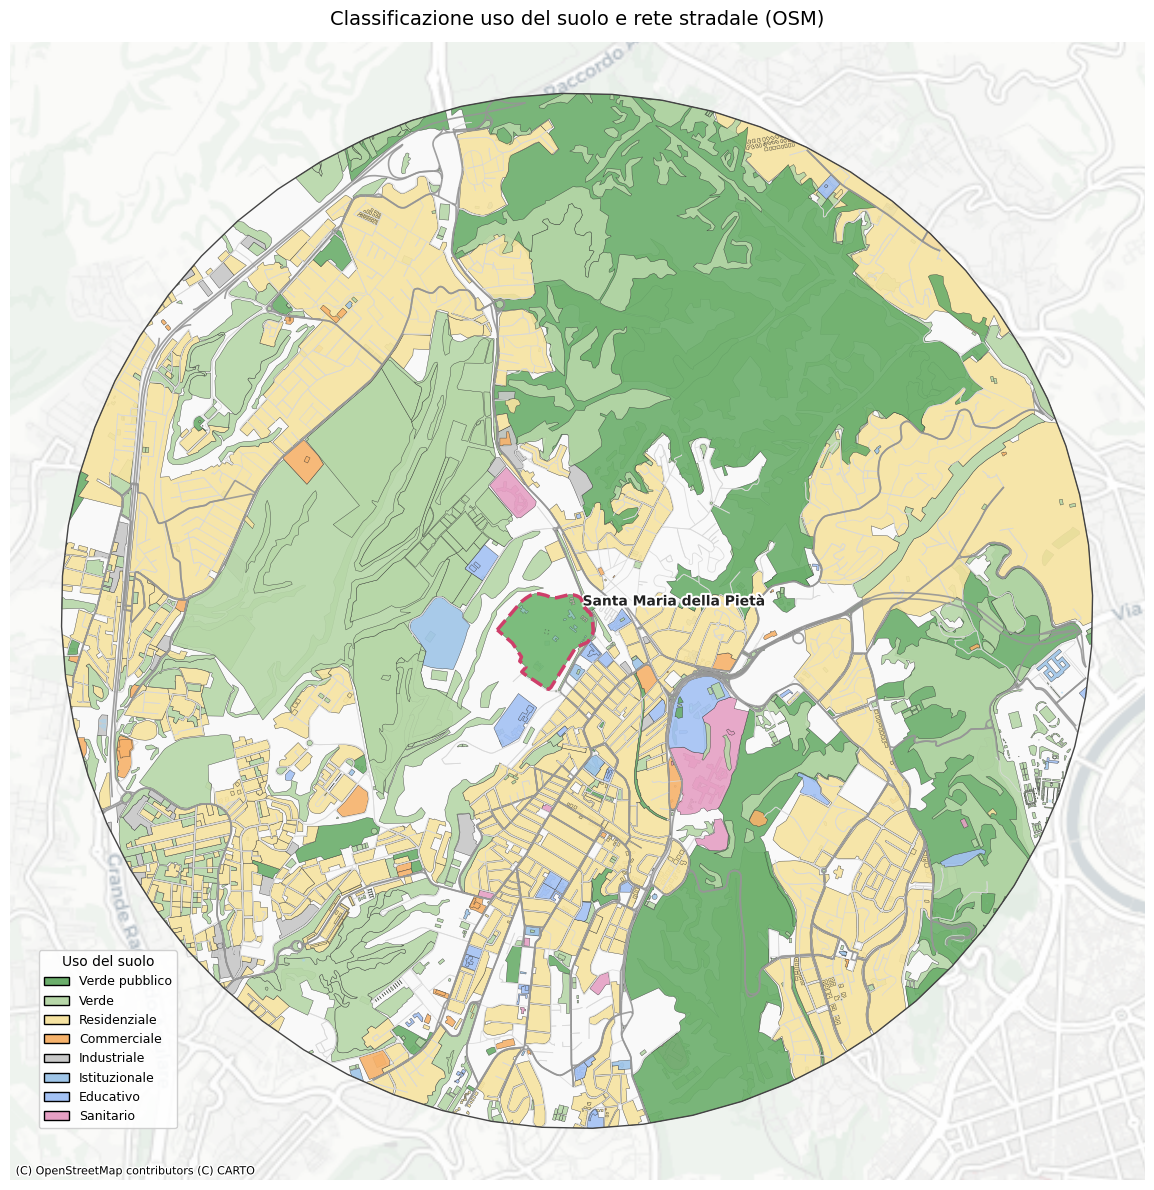

In [9]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Acque (poligoni e linee) ---
WATER_POLY_COLOR = "#A6D3F0"
WATER_LINE_COLOR = "#4AA3DF"

if 'water_poly3857' in globals() and not water_poly3857.empty:
    water_poly3857.plot(
        ax=ax,
        color=WATER_POLY_COLOR,
        edgecolor="none",
        alpha=0.6,
        zorder=22
    )

if 'water_line3857' in globals() and not water_line3857.empty:
    water_line3857.plot(
        ax=ax,
        color=WATER_LINE_COLOR,
        linewidth=1.2,
        alpha=0.9,
        zorder=28
    )


# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
# plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()


In [10]:
# === Escludi POI senza nome valido ===
import numpy as np
poi_df = gdf_classified.copy()
poi_df = poi_df[poi_df["name"].notna() & (poi_df["name"].str.strip() != "")].copy()

# === Info aggiuntive
poi_df["geometry_type"] = poi_df.geometry.geom_type
poi_df["centroide"] = poi_df.geometry.centroid
poi_df["x"] = poi_df["centroide"].x
poi_df["y"] = poi_df["centroide"].y

campi_utili = [
    "name",
    "landuse_class",
    "landuse", "amenity", "leisure", "building", "natural",
    "access", "operator",
    "geometry_type", "x", "y"
]
# === Assegna ID numerico
poi_df = poi_df.reset_index(drop=True)
poi_df["poi_id"] = np.arange(1, len(poi_df) + 1)

poi_df = poi_df[campi_utili + ["geometry", "poi_id"]]



poi_df

name  landuse_class landuse  \
0                               Court 11          Verde     NaN   
1                               Court 13          Verde     NaN   
2                                Court 9          Verde     NaN   
3                               Court 10          Verde     NaN   
4                                    RAI    Industriale     NaN   
..                                   ...            ...     ...   
199                                  Erg    Commerciale     NaN   
200                                   Q8    Commerciale     NaN   
201       Chiesa di Sant'Andrea Avellino  Istituzionale     NaN   
202        Associazione Sportiva Ottavia          Verde     NaN   
203  Parco Giochi di Ipogeo degli Ottavi          Verde     NaN   

              amenity     leisure    building natural access  \
0                 NaN       pitch         NaN     NaN    NaN   
1                 NaN       pitch         NaN     NaN    NaN   
2                 NaN       pitch         NaN     NaN    NaN   
3                 NaN       pitch         NaN     NaN    NaN   
4                 NaN         NaN  industrial     NaN    NaN   
..                ...         ...         ...     ...    ...   
199              fuel         NaN        roof     NaN    NaN   
200              fuel         NaN        roof     NaN    NaN   
201  place_of_worship         NaN      church     NaN    NaN   
202               NaN       pitch         NaN     NaN    NaN   
203               NaN  playground         NaN     NaN    NaN   

                                              operator geometry_type  \
0                                                  NaN       Polygon   
1                                                  NaN       Polygon   
2                                                  NaN       Polygon   
3                                                  NaN       Polygon   
4                                                  NaN       Polygon   
..                                                 ...           ...   
199  G.R.A. Carburanti di Bucci Marco e C. Società ...       Polygon   
200           Petrolgest di Vincenzo Cultrera - S.A.S.       Polygon   
201                                                NaN       Polygon   
202                                                NaN       Polygon   
203                                                NaN       Polygon   

             x          y                                           geometry  \
0    12.456785  41.927426  POLYGON ((12.45684 41.92761, 12.45695 41.92729...   
1    12.457387  41.927873  POLYGON ((12.45728 41.92767, 12.45729 41.92771...   
2    12.456351  41.927344  POLYGON ((12.45641 41.92752, 12.45651 41.9272,...   
3    12.456569  41.927385  POLYGON ((12.45662 41.92757, 12.45673 41.92725...   
4    12.445576  41.919410  POLYGON ((12.44587 41.91959, 12.44586 41.91956...   
..         ...        ...                                                ...   
199  12.385448  41.957822  POLYGON ((12.38543 41.95801, 12.38564 41.95782...   
200  12.385093  41.958153  POLYGON ((12.38505 41.95833, 12.38512 41.95827...   
201  12.411806  41.965249  POLYGON ((12.41191 41.96547, 12.41202 41.96523...   
202  12.408062  41.964862  POLYGON ((12.4085 41.96531, 12.4084 41.96436, ...   
203  12.407230  41.966322  POLYGON ((12.40679 41.96671, 12.40689 41.96662...   

     poi_id  
0         1  
1         2  
2         3  
3         4  
4         5  
..      ...  
199     200  
200     201  
201     202  
202     203  
203     204  

[204 rows x 14 columns]

## POI SELECTION

In [11]:
# Lista di ID scelti manualmente (oppure filtrali per distanza, categoria ecc.)
poi_inclusi_id = [5, 9, 17, 28, 29, 30, 32, 33, 37, 51, 56, 67, 77, 83, 93, 101, 126, 153, 163, 173, 189]  # es. quelli che ti interessano
poi_selected = poi_df[poi_df["poi_id"].isin(poi_inclusi_id)].copy()
poi_selected.head(3)

name   landuse_class landuse amenity leisure  \
4                               RAI     Industriale     NaN     NaN     NaN   
8   Riserva Naturale di Monte Mario  Verde pubblico     NaN     NaN    park   
16                Villa Monte Mario     Commerciale     NaN     NaN     NaN   

      building natural access           operator geometry_type          x  \
4   industrial     NaN    NaN                NaN       Polygon  12.445576   
8          NaN     NaN    NaN        Roma Natura  MultiPolygon  12.450831   
16       hotel     NaN    NaN  Suore Carmelitane       Polygon  12.444895   

            y                                           geometry  poi_id  
4   41.919410  POLYGON ((12.44587 41.91959, 12.44586 41.91956...       5  
8   41.932227  MULTIPOLYGON (((12.44502 41.93231, 12.44533 41...       9  
16  41.929062  POLYGON ((12.44509 41.92931, 12.44527 41.92909...      17

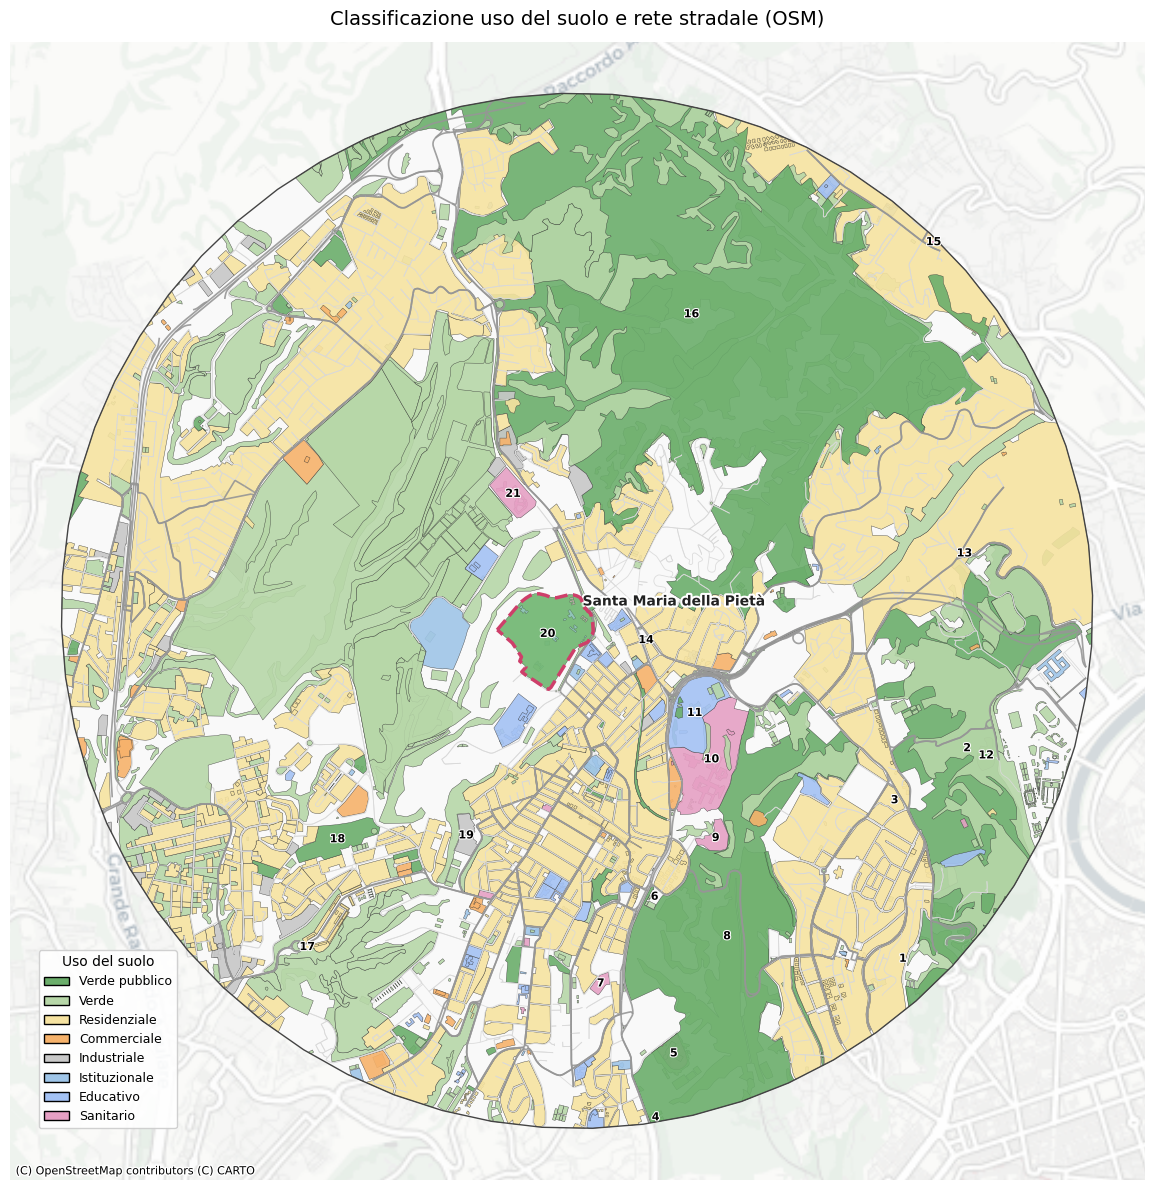

In [12]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === POI selezionati (marker rossi centrati) ===

# Assicura che il CRS sia EPSG:3857
poi_selected = poi_selected.to_crs(3857)

# Calcola il centroide per ogni geometria
poi_selected["centroide"] = poi_selected.geometry.centroid

# Plotta i marker centrati sui centroidi
from matplotlib.patches import Circle

# --- Aggiungi numeri con sfondo in stile categoria
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    pt = row["centroide"]
    
    # Colore in base alla categoria (usa "Non classificato" se mancante)
    categoria = row.get("landuse_class", "Non classificato")
    colore_sfondo = palette_landuse.get(categoria, palette_landuse["Non classificato"])

    # Cerchio colorato di sfondo (tipo badge)
    circle = Circle((pt.x, pt.y), radius=20, facecolor=colore_sfondo,
                    edgecolor="white", linewidth=0.8, zorder=199)
    ax.add_patch(circle)
    
    # Testo (numerino centrato) sopra il cerchio
    ax.text(
        pt.x, pt.y, str(i),
        fontsize=8, weight="bold", color="black",
        ha="center", va="center",
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
        zorder=200
    )




# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
# plt.savefig("mappa_landuse_smdp.png", dpi=200, bbox_inches="tight")
plt.show()


## poi plot

In [13]:
import pandas as pd

righe = []
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    # Prendi un nome “robusto” (fallback se manca 'name')
    nome = (row.get("name")
            or row.get("Nome")
            or row.get("label")
            or row.get("ref")
            or "")

    righe.append({
        "numero": i,                         # numero mostrato sul grafico
        "poi_id": row.get("poi_id", None),   # ID interno se presente
        "nome": nome,
        "category": row.get("category", None),
        "landuse_class": row.get("landuse_class", None)
    })

mappa_num_nomi = pd.DataFrame(righe)
print(mappa_num_nomi)
# opzionale: salvalo per controllo
# mappa_num_nomi.to_csv("mappa_poi_numeri.csv", index=False)


    numero  poi_id                                        nome category  \
0        1       5                                         RAI     None   
1        2       9             Riserva Naturale di Monte Mario     None   
2        3      17                           Villa Monte Mario     None   
3        4      28                            Pineta Sacchetti     None   
4        5      29       ASL RME - Dipartimento salute mentale     None   
5        6      30               Chiesa di Gesù Divino Maestro     None   
6        7      32                          Ospedale Cristo Re     None   
7        8      33           Parco Regionale Urbano del Pineto     None   
8        9      37                Complesso Integrato Columbus     None   
9       10      51  Policlinico Universitario Agostino Gemelli     None   
10      11      56        Università Cattolica del Sacro Cuore     None   
11      12      67                          Parco dello Stadio     None   
12      13      77       

In [14]:
from IPython.display import HTML, display

# 1) Seleziona solo le colonne necessarie e ordina per numero
tab = (
    mappa_num_nomi[["numero", "nome"]]
    .sort_values("numero")
    .rename(columns={"numero": "#", "nome": "POI"})
)

# 2) HTML + CSS minimale
css = """
<style>
table.tbl { border-collapse: collapse; font-family: system-ui, sans-serif; font-size: 14px; }
table.tbl th, table.tbl td { padding: 6px 10px; border-bottom: 1px solid #ddd; }
table.tbl tr:nth-child(even) { background: #fafafa; }
table.tbl th { text-align: left; }
caption { caption-side: top; text-align: left; font-weight: 600; margin-bottom: 6px; }
</style>
"""

html_table = tab.to_html(index=False, escape=True, border=0, classes="tbl")
html = css + "<caption>Mappa POI: numero ↔ nome</caption>" + html_table

# 3) Salva su file
with open("mappa_poi_numeri.html", "w", encoding="utf-8") as f:
    f.write(html)

# 4) (opzionale) mostra in notebook
display(HTML(html))

print("Creato file: mappa_poi_numeri.html")


Creato file: mappa_poi_numeri.html


## edifici

In [15]:
import osmnx as ox
import geopandas as gpd

# 1) AOI in WGS84 come (Multi)Polygon shapely
aoi_wgs84_geom = aoi3857.to_crs(4326).unary_union  # shapely (Polygon/MultiPolygon)

# 2) Fetch buildings (compatibile v1.x / v2.x)
if hasattr(ox, "features_from_polygon"):
    buildings = ox.features_from_polygon(aoi_wgs84_geom, tags={"building": True})
else:
    buildings = ox.geometries_from_polygon(aoi_wgs84_geom, tags={"building": True})

# 3) Tieni solo poligoni e proietta a 3857
buildings = buildings[buildings.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].copy()
buildings3857 = buildings.to_crs(3857)

# 4) Clip all’AOI (opzionale ma consigliato)
try:
    buildings3857 = gpd.clip(buildings3857, aoi3857)
except Exception:
    pass

# 5) Plot “soft” (sotto le strade)
if not buildings3857.empty:
    buildings3857.plot(
        ax=ax,
        color="#000000",      # nero con alpha bassa = grigio tenue
        alpha=0.06,
        edgecolor="#777777",
        linewidth=0.15,
        zorder=25             # > landuse (10), < strade (30/40)
    )


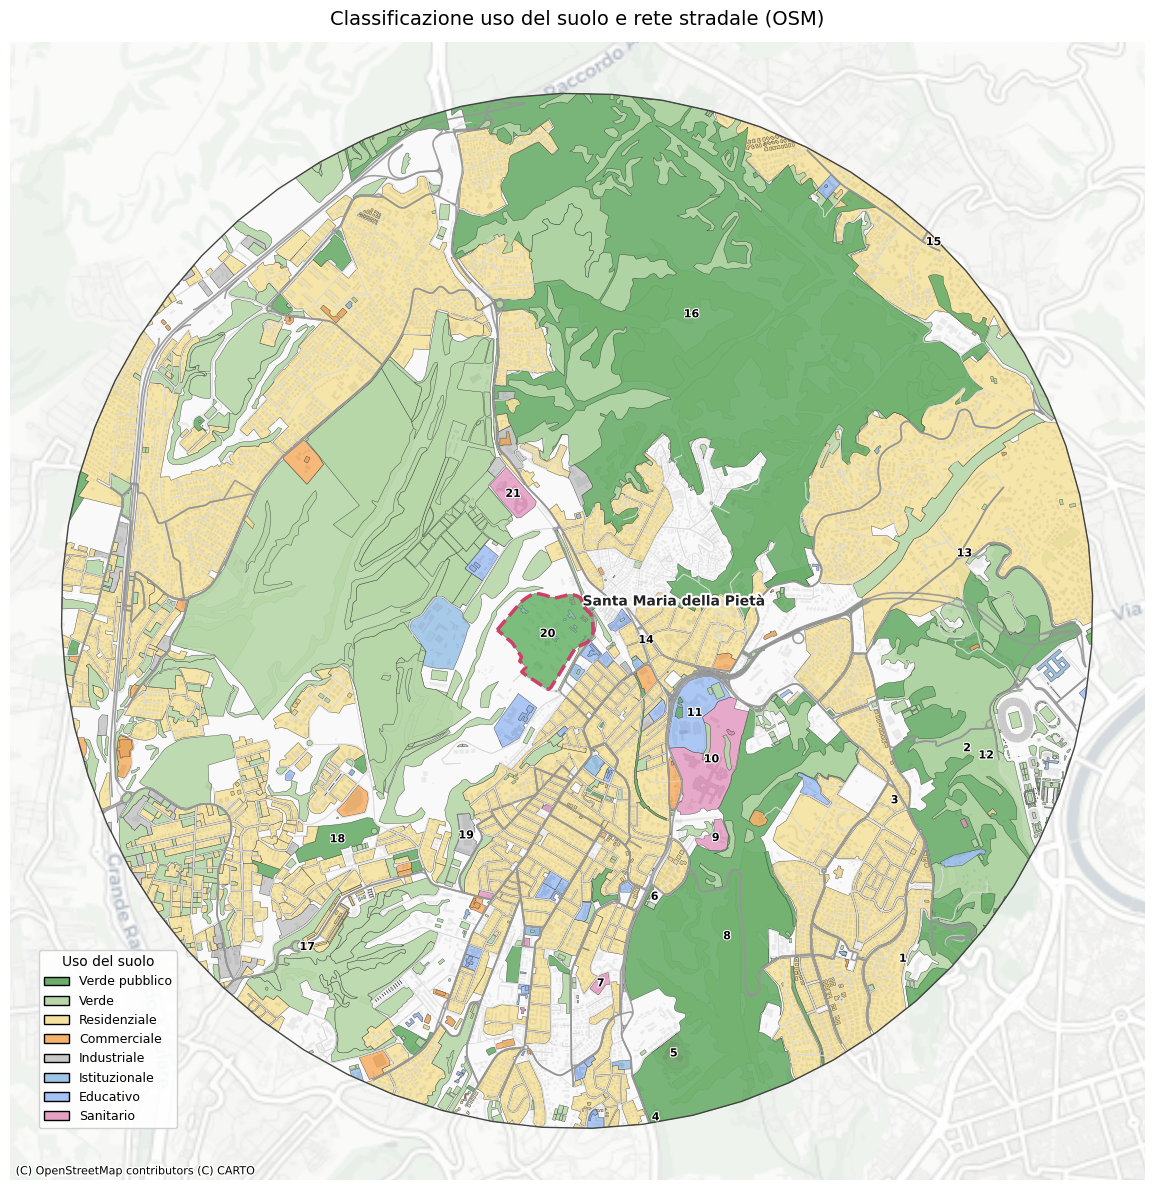

In [16]:
import matplotlib.patheffects as pe
from shapely.geometry import Point
from matplotlib.patches import Patch

# === PALETTE AGGIORNATA ===
palette_landuse = {
    "Verde pubblico": "#6BAE6B",
    "Verde": "#B7D7A8",
    "Residenziale": "#F6E3A1",
    "Commerciale": "#F6B26B",
    "Industriale": "#C8C8C8",
    "Istituzionale": "#9FC5E8",
    "Educativo": "#A4C2F4",
    "Sanitario": "#E6A0C4",
    "Non classificato": "#DADADA"
}

# === 1. Crea la figura ===
fig, ax = plt.subplots(figsize=(12, 12))

# --- Sfondo neutro ---
aoi3857.plot(ax=ax, color="#F9F9F9", zorder=-5)

# --- Poligoni classificati ---
gdf_classified_3857.plot(
    ax=ax,
    column="landuse_class",
    color=gdf_classified_3857["landuse_class"].map(palette_landuse),
    legend=False,
    alpha=0.9,
    edgecolor="#333333",
    linewidth=0.3,
    zorder=10
)

# --- Edifici (soft) ---
# Se hai già un GeoDataFrame buildings3857 nel tuo notebook:
b = locals().get("buildings3857", None)

# In caso contrario, prova a scaricarli da OSM (serve internet)
if b is None:
    import osmnx as ox
    aoi_wgs84_geom = aoi3857.to_crs(4326).unary_union
    if hasattr(ox, "features_from_polygon"):
        b_raw = ox.features_from_polygon(aoi_wgs84_geom, tags={"building": True})
    else:
        b_raw = ox.geometries_from_polygon(aoi_wgs84_geom, tags={"building": True})
    b = b_raw[b_raw.geometry.geom_type.isin(["Polygon", "MultiPolygon"])].to_crs(3857)
    try:
        import geopandas as gpd
        b = gpd.clip(b, aoi3857)
    except Exception:
        pass

if b is not None and not b.empty:
    b.plot(
        ax=ax,
        color="#000000",   # nero con alpha bassa -> grigio tenue
        alpha=0.06,
        edgecolor="#777777",
        linewidth=0.15,
        zorder=25          # > landuse (10), < strade (30/40)
    )


# --- Strade ---
if not edges_minor3857.empty:
    edges_minor3857.plot(ax=ax, color="#d9d9d9", linewidth=0.6, alpha=0.9, zorder=30)
if not edges_major3857.empty:
    edges_major3857.plot(ax=ax, color="#969696", linewidth=1.2, alpha=0.9, zorder=40)

# --- AOI (contorno) ---
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0, zorder=50)

# --- Basemap ---
if PARAMS["use_basemap"] and HAS_CTX:
    basemap_key = PARAMS.get("basemap", "positron").lower()
    basemap = BASEMAP_PROVIDERS.get(basemap_key, ctx.providers.CartoDB.Positron)
    ctx.add_basemap(ax, source=basemap, crs=gdf_classified_3857.crs, zorder=-10)

# --- Punto centrale ---
point_geom = Point(PARAMS["center_latlon"][1], PARAMS["center_latlon"][0])  # (lon, lat)
point_3857 = gpd.GeoDataFrame(geometry=[point_geom], crs=4326).to_crs(3857)
x, y = point_3857.geometry.x.iloc[0], point_3857.geometry.y.iloc[0]
p = point_3857.geometry.iloc[0]

# === Trova la geometria "verde" che contiene/interseca il punto ===
mask_verde = gdf_classified_3857["landuse_class"].isin(["Verde", "Verde pubblico"])
gdf_verde = gdf_classified_3857[mask_verde]
gdf_verde_hit = gdf_verde[gdf_verde.intersects(p)].copy()

# === Evidenzia la geometria del Comprensorio ===
if not gdf_verde_hit.empty:
    gdf_verde_hit.boundary.plot(
        ax=ax,
        color="#CE3F6A",
        linewidth=2.5,
        linestyle="--",
        zorder=150
    )
    gdf_verde_hit.plot(
        ax=ax,
        color="#81C784",
        alpha=0.4,
        edgecolor=None,
        zorder=140
    )

# --- Etichetta: solo testo, senza stella ---
ax.text(
    x + 50, y + 50, "Santa Maria della Pietà",
    fontsize=10, fontweight='bold', color='#222222',
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],
    zorder=101
)

# === POI selezionati (marker rossi centrati) ===

# Assicura che il CRS sia EPSG:3857
poi_selected = poi_selected.to_crs(3857)

# Calcola il centroide per ogni geometria
poi_selected["centroide"] = poi_selected.geometry.centroid

# Plotta i marker centrati sui centroidi
from matplotlib.patches import Circle

# --- Aggiungi numeri con sfondo in stile categoria
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    pt = row["centroide"]
    
    # Colore in base alla categoria (usa "Non classificato" se mancante)
    categoria = row.get("landuse_class", "Non classificato")
    colore_sfondo = palette_landuse.get(categoria, palette_landuse["Non classificato"])

    # Cerchio colorato di sfondo (tipo badge)
    circle = Circle((pt.x, pt.y), radius=20, facecolor=colore_sfondo,
                    edgecolor="white", linewidth=0.8, zorder=199)
    ax.add_patch(circle)
    
    # Testo (numerino centrato) sopra il cerchio
    ax.text(
        pt.x, pt.y, str(i),
        fontsize=8, weight="bold", color="black",
        ha="center", va="center",
        path_effects=[pe.withStroke(linewidth=1.5, foreground="white")],
        zorder=200
    )




# === Legenda ===
order = [
    "Verde pubblico", "Verde",
    "Residenziale", "Commerciale", "Industriale",
    "Istituzionale", "Educativo", "Sanitario", "Non classificato"
]

legend_labels = [
    Patch(facecolor=palette_landuse[label], edgecolor="k", label=label)
    for label in order if label in gdf_classified_3857["landuse_class"].unique()
]

ax.legend(
    handles=legend_labels,
    title="Uso del suolo",
    loc="lower left",
    bbox_to_anchor=(0.02, 0.04),
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    facecolor="white",
    framealpha=0.9
)

# === Titolo e output ===
ax.set_title("Classificazione uso del suolo e rete stradale (OSM)", fontsize=14, pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("mappa_landuse_FOCUS_smdp.png", dpi=200, bbox_inches="tight")
plt.show()



In [17]:
import pandas as pd

righe = []
for i, (_, row) in enumerate(poi_selected.iterrows(), start=1):
    # Prendi un nome “robusto” (fallback se manca 'name')
    nome = (row.get("name")
            or row.get("Nome")
            or row.get("label")
            or row.get("ref")
            or "")

    righe.append({
        "numero": i,                         # numero mostrato sul grafico
        "poi_id": row.get("poi_id", None),   # ID interno se presente
        "nome": nome,
        "category": row.get("category", None),
        "landuse_class": row.get("landuse_class", None)
    })

mappa_num_nomi = pd.DataFrame(righe)
print(mappa_num_nomi)
# opzionale: salvalo per controllo
# mappa_num_nomi.to_csv("mappa_poi_numeri.csv", index=False)


    numero  poi_id                                        nome category  \
0        1       5                                         RAI     None   
1        2       9             Riserva Naturale di Monte Mario     None   
2        3      17                           Villa Monte Mario     None   
3        4      28                            Pineta Sacchetti     None   
4        5      29       ASL RME - Dipartimento salute mentale     None   
5        6      30               Chiesa di Gesù Divino Maestro     None   
6        7      32                          Ospedale Cristo Re     None   
7        8      33           Parco Regionale Urbano del Pineto     None   
8        9      37                Complesso Integrato Columbus     None   
9       10      51  Policlinico Universitario Agostino Gemelli     None   
10      11      56        Università Cattolica del Sacro Cuore     None   
11      12      67                          Parco dello Stadio     None   
12      13      77       